In [2]:
import pandas as pd
import numpy as np
import os

from time import time
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, auc
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from skimage.feature import hog
from PIL import Image

D:\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
name_path = './archive/lfw_allnames.csv'
images_path = './archive/lfw-deepfunneled/lfw-deepfunneled'

In [4]:
df_names = pd.read_csv(name_path)
min_faces_per_person = 80
df_names = df_names.loc[df_names["images"] >= min_faces_per_person, :]
names = list(df_names["name"])

In [5]:
X = []
Y = []
for name in names:
    dir_path = os.path.join(images_path, name)
    list_images_name = os.listdir(dir_path)
    for image_name in list_images_name:
        image_path = os.path.join(dir_path, image_name)
        img_rgb = plt.imread(image_path)
        X.append(img_rgb)
        Y.append(name)
    print(f"Class: {name}, number of samples: {len(list_images_name)}.")
X = np.asarray(X)
Y = np.asarray(Y)

Class: Colin_Powell, number of samples: 236.
Class: Donald_Rumsfeld, number of samples: 121.
Class: George_W_Bush, number of samples: 530.
Class: Gerhard_Schroeder, number of samples: 109.
Class: Tony_Blair, number of samples: 144.


In [6]:
def create_features(img, show_hog=False):
    # flatten image
    color_features = img.flatten()
    # convert image to greyscale
    grey_image = np.array(0.299 * img[:, :, 0] + 0.587 * img[:, :, 1] + 0.114 * img[:, :, 2])
    # get HOG features from greyscale image
    hog_features, hog_image = hog(grey_image, visualize=True, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    if show_hog:
        plt.imshow(hog_image, cmap="gray")
    # combine color and hog features into a single array
    flat_features = np.hstack((color_features, hog_features))
    return flat_features

In [23]:
def pca (im, k):
    im1 = np.hstack((im[:,:,0], im[:,:,1], im[:,:,2]))
    # normalization. For each column, mean=0, sd=1
    means = np.mean(im1, axis=0).reshape(1, -1)
    sds = np.std(im1, axis=0).reshape(1, -1)
    sds += 0.01
    im2 = (im1 - means) / sds

    # compute the eigenvalues and eigenvectors of {A^T}A
    S = np.matmul(im2.T, im2)
    W, Q = np.linalg.eig(S)

    # sort the eigenvalues and corresponding eigenvectors
    # from largest to smallest
    w_args = np.flip(np.argsort(W))
    Q = Q[:, w_args]
    W = W[w_args]

    # calculate new scores (coordinates)
    C = np.matmul(im2, Q)

    # reconstruct the image data with k PCs
    im3 = np.matmul(C[:, :k], Q.T[:k, :])
    im3 = im3 * sds + means
    im3 = im3.astype('uint8')

    return im3

In [32]:
feature_matrix = []
X_pca = []
for x in X:
    #flat_features = create_features(x)
    #feature_matrix.append(flat_features)
    x_pca = pca(x, 50)
    X_pca.append([x_pca])
    

C:\Users\CEG\AppData\Local\Temp\ipykernel_3956\1158170767.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  im3 = im3.astype('uint8')


In [ ]:
# get shape of feature matrix
feature_matrix = np.asarray(feature_matrix)
print('Feature matrix shape is: ', feature_matrix.shape)

# define standard scaler
ss = StandardScaler()
# run this on our feature matrix
bees_stand = ss.fit_transform(feature_matrix)

# pca = PCA(n_components=500)
# # use fit_transform to run PCA on our standardized matrix
# pca.fit(bees_stand)
X_pca = pca(bees_stand, 500)

In [33]:
# label_encoder object knows  
# how to understand word labels. 
label_encoder = LabelEncoder() 
  
# Encode labels in column 'species'. 
Y = label_encoder.fit_transform(Y) 

In [34]:
X_train, X_test, Y_train, Y_test = train_test_split(X_pca, Y, random_state=42)

In [35]:
clf = SVC(class_weight='balanced', random_state=42)

In [36]:
parameters = {'C': [0.1, 1, 10],
             'gamma': [1e-3, 1e-6, 1e-9],
             'kernel': ['rbf', 'linear']}
grid_search = GridSearchCV(clf, parameters, n_jobs=-1, cv=5)

In [37]:
t0 = time()
grid_search.fit(X_train, Y_train)
print("grid_search in %0.fs" % (time() - t0))
print(f"The best model is: {grid_search.best_params_}.")
print("The best mean accuracy: ", grid_search.best_score_)

ValueError: 
All the 90 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "D:\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\anaconda3\Lib\site-packages\sklearn\svm\_base.py", line 192, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "D:\anaconda3\Lib\site-packages\sklearn\base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 1106, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "D:\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 915, in check_array
    raise ValueError(
ValueError: Found array with dim 4. SVC expected <= 2.


(250, 750)


C:\Users\CEG\AppData\Local\Temp\ipykernel_3956\2530921081.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  im3 = im3.astype('uint8')


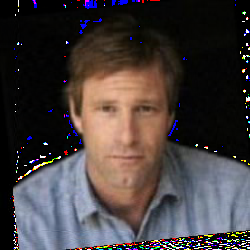

In [11]:
from PIL import Image
import numpy as np

img_fn = "./archive/lfw-deepfunneled/lfw-deepfunneled/Aaron_Eckhart/Aaron_Eckhart_0001.jpg"
img = Image.open(img_fn)

# convert to RGB mode
rgb_img = img.convert('RGB')

# convert to numpy array
im = np.array(rgb_img) 

# simply combine the three (R,G,B) channels
im1 = np.hstack((im[:,:,0], im[:,:,1], im[:,:,2]))
print(im1.shape)

# normalization. For each column, mean=0, sd=1
means = np.mean(im1, axis=0).reshape(1, -1)
sds = np.std(im1, axis=0).reshape(1, -1)
im2 = (im1 - means) / sds

# compute the eigenvalues and eigenvectors of {A^T}A
S = np.matmul(im2.T, im2)
W, Q = np.linalg.eig(S)

# sort the eigenvalues and corresponding eigenvectors
# from largest to smallest
w_args = np.flip(np.argsort(W))
Q = Q[:, w_args]
W = W[w_args]

# calculate new scores (coordinates)
C = np.matmul(im2, Q)

k = 50   # CHANGE ME! number of PCs to keep

# reconstruct the image data with k PCs
im3 = np.matmul(C[:, :k], Q.T[:k, :])
im3 = im3 * sds + means
im3 = im3.astype('uint8')

# reconstruct the three (R,G,B) channels
im3_channels = np.hsplit(im3, 3)
im4 = np.zeros_like(im)
for i in range(3):
    im4[:,:,i] = im3_channels[i]
Image.fromarray(im4)
